# Structure Learning

---

In this notebook we will implement a function that learns the *structure* and *parameters* of a Bayesian network using *score-based search over a search space restricted by a pre-determined variable order*. We will then use this function to automatically find a good graph structure for the stroke example.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from bayesian_network import BayesNet, Variable
from utils import maximum_likelihood_estimate, log_likelihood, get_default_bayes_net, draw_graph, evaluate_bayes_net

#### General Remarks

Since we are dealing with graphical models, we need to store the structure and the distribution tables in some way. In this exercise, we're using a list containing a descriptor for each variable. For example, assume we have three random variables A, B, and C. Further assume we want to encode the model that factorizes in the following way:

$$ P(A, B, C) = P(A) \cdot P(B \mid A) \cdot P(C \mid A, B).$$

Variables $A, B$ and $C$ will get indices 0, 1, and 2, respectively. The corresponding list will then look like this (following the same naming conventions as used in the previous exercises):

In [2]:
_A_, _B_, _C_ = 0, 1, 2
# create dummy PDTs
pdts = [
    (np.ones((2,))*0.5, (_A_,)), 
    (np.ones((2,2))*0.5, (_B_, _A_)), 
    (np.ones((2,2,2))*0.5, (_C_, _A_, _B_))
]

Each tuple in the list corresponds to a variable, where
 - the first element in each tuple contains the (conditional) PDT, 
 - the second one describes the table's semantics (indices).

A new BayesNet can be created by passing a tuple for each variable to the constructor. Use the asterisk (\*) operator to pass an arbitrary number of tuples as arguments to the constructor:

In [3]:
bn = BayesNet(*pdts)

You can access the PDTs and the corresponding indices of a *BayesNet* object via the member variables `pdts` and `indices`, respectively:

In [4]:
print(bn.pdts)
print(bn.indices)



(array([0.5, 0.5]), array([[0.5, 0.5],
       [0.5, 0.5]]), array([[[0.5, 0.5],
        [0.5, 0.5]],

       [[0.5, 0.5],
        [0.5, 0.5]]]))
((0,), (1, 0), (2, 0, 1))


Note that they are returned as tuples, to make clear they should not be modified. With `list(bn.pdts)` and `list(bn.indices)` you can convert them back to lists if needed.

We are also providing a new utility function to draw the structure of a BayesNet:

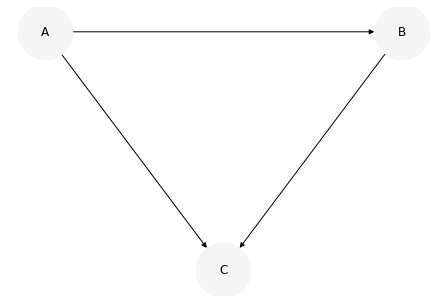

In [5]:
draw_graph(
    bn, 
    node_names=['A', 'B', 'C'], 
    pos={'A': [0., 1.], 'B': [1., 1.], 'C': [.5, .5]}
)

In [6]:
help(draw_graph)

Help on function draw_graph in module utils:

draw_graph(bayes_net: bayesian_network.BayesNet, node_names: list = None, pos: dict = None) -> None
    Draws the Bayesian net.
    :param bayes_net: a BayesNet object representing the graph structure to draw.
    :param node_names: Display Name of the variables. 
                       Defaults to values for the stroke-example.
    :param pos: position of the variables (dict: key=variable_name, value: list: x, y). 
                Defaults to values for the stroke-example.



### Bayes Information Criterion

<div class="alert alert-warning">
    Implement the <i>bic_score</i> function, which computes the Bayes Information Criterion Score (BIC-Score) for a network graph structure under the given data, assuming a Dirichlet prior over the model parameters.
</div>

`bic_score` takes two parameters:
- `data` is a NumPy array of shape `(num_samples, num_variables)`.
- `bayes_net` is a BayesNet object, representing the graph structure for which to compute the BIC-Score. *Assume that the parameters of this bayes_net are set to the maximum likelihood estimate w.r.t. to the data*.

`bic_score` must return one object:
- The BIC-Score, a floating-point number < 0.

In [7]:
def bic_score(data: np.ndarray, bayes_net: BayesNet) -> float:
    """
    Computes the Bayesian information criterion score assuming a Dirichlet prior over the model parameters.
    :param data:      data to compute the bic score of, a np.ndarray of shape (num_samples, len(bayes_net)).
    :param bayes_net: the model, a BayesNet object.
    :return:          BIC score
    """
    
    assert data.shape[1] == len(bayes_net)    
    
    #compute log_likelihood
    ll = log_likelihood(data, bayes_net)

    #compute number of independent parameters:
    dim_g = 0
    for variable in bayes_net:
        vars = []
        for i in range(len(variable.pdt.shape)):
            if i == variable.id:
                vars.append(variable.pdt.shape[i] - 1)
            else:
                vars.append(variable.pdt.shape[i])
            
        dim_g += np.prod(vars)
    
    bic = ll - (np.log(data.shape[0])/2) * dim_g

    
    return bic



In [8]:
# sanity check
bayes_net = get_default_bayes_net()
data = np.array([[0,0,0,0,0], [1,1,1,1,1], [1,1,0,0,0]], dtype=np.int64)

bic = bic_score(data, bayes_net)
assert isinstance(bic,float), f'`bic_score` should return type float but returns {type(bic)}'
assert -16 < bic < -15, f'BIC needs to be in ]-16, -15[, but got {bic}'


### Score Based Search
<div class="alert alert-warning">
To implement <i>learn_net</i>, a function that learns the structure and parameters of a Bayesian net using score-based search over a search space restricted by a pre-determined variable order. (6 points)
</div>

`learn_net` takes three parameters:
- `data` is a NumPy array of shape `(num_samples, num_variables)`.
- `variable_order` is a list of variable ids (ints) specifying the topological order.
- `score_fun` is the function used to score the candidate graph structure — defaults to `bic_score`. Higher score means better model. 

`learn_net` must return one object:
- a BayesNet object, which represents the model with the highest score under the given topological order.


In [9]:
import itertools as it
import copy

def learn_net(data: np.ndarray, variable_order: list, score_fun: Callable[[np.ndarray, BayesNet], float]=bic_score) -> BayesNet:
    """
    Learns the structure and parameters of a Bayesian net using score-based search over a search space restricted by a pre-determined variable order.
    :param data: the training data, a NumPy array of shape (num_samples, len(bayes_net)).
    :param variable_order: a list containing the topological order of the variables (list of indices).
    :param score_fun:  is the function used to score the candidate graph structure — defaults to `bic_score`. 
    :return: a BayesNet object, which represents the model with the highest BIC-Score under the given topological order.
    """
    assert len(variable_order) == data.shape[1]
    
    best_pdts = [maximum_likelihood_estimate(data, variable_id) for variable_id in variable_order]
    best_indices = [(variable_id,) for variable_id in variable_order]

    # you can create a BayesNet from these descriptors with:
    best_model = BayesNet(*zip(best_pdts, best_indices))
    for i, variable_id in enumerate(variable_order):        
        combination = [it.combinations(variable_order[:i], p) for p in range(1, len(variable_order[:i])+1)]
        for parent_idxs in it.chain.from_iterable(combination):
                
                pdts = list(best_model.pdts)
                indices = list(best_model.indices)
                
                pdts[i] = maximum_likelihood_estimate(data, variable_id, parent_idxs)
                indices[i] = (variable_id,) + parent_idxs
                
                candidate = BayesNet(*zip(pdts, indices))
                
                if score_fun(data, candidate) > score_fun(data,  best_model):
                    best_model = candidate   
    return best_model

In [10]:
data = np.array([[0,0,0,0,1],[0,0,0,1,0],[0,1,0,1,0],[1,0,0,1,0],[0,1,0,0,1],[1,0,0,0,1]]*10, dtype=np.int64)
bayes_net = learn_net(data, [0,1,2,3,4])
assert len(bayes_net) == 5, f'\nBayesNet should contain all 5 Variables.' \
                            f'\nIt only contained {len(bayes_net)} being {set(it.chain(*bayes_net.indices))}.'\
                            f'\nMissing: {set(range(5))-set(it.chain(*bayes_net.indices))}.'\
                            f'\nMost likely there is an error in how you construct your `new` BayesNet during learning.'

assert np.all(np.isclose(bayes_net.pdts[0], np.array([0.66, 0.33]), atol=0.01))
assert bayes_net.indices[1] == (1,0), 'Algorithm should favor connection B_A'

bayes_net = learn_net(data, [0,1,2,3,4], score_fun=lambda d, n: 0.0)
assert bayes_net.indices[1] == (1,), 'it seems learn_net() uses bic_score() instead of score_fun()'


## Example

---


Consider a model comprising the following random variables:

 - A ... Alcoholism
 - H ... High Blood Pressure
 - S ... Stroke
 - C ... Confusion
 - V ... Vertigo
 
Instead of trying different model structures manually, we want to determine the best structure automatically. 

In [12]:
_A_, _H_, _S_, _C_, _V_ = 0, 1, 2, 3, 4

model2_ps3_indices = [(_A_,), (_H_, _A_), (_S_, _H_), (_C_, _A_, _S_), (_V_, _S_)]

train_small = np.loadtxt('data/train_small.txt', dtype=np.int64)
train_medium = np.loadtxt('data/train_medium.txt', dtype=np.int64)
train_big = np.loadtxt('data/train_big.txt', dtype=np.int64)
test = np.loadtxt('data/test.txt', dtype=np.int64)


She decides to use *score-based search* to find the best model. She wants to *define a variable order* to restrict the search space strongly. She considers the following configurations:

<table style="border-collapse:collapse;border-spacing:0;border-color:#ccc"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0">Variable Order</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0">Score Function</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">A, H, S, C, V</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">V, C, S, H, A</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">C, A, H, V, S<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">A, H, S, C, V</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">Log-Likelihood</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">-</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">PS2, Model 2 (defined below)</td></tr></table>

<div class="alert alert-warning">
    
Use `learn_net` function to learn a graph structure and the parameters for the different configurations and for all data sets (`train_small`, `train_medium`, and `train_big`). </div>


####### Graphs of  small  dataset size ###########
Ordered Graph


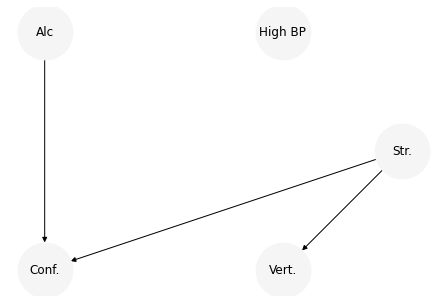

Reverse Graph


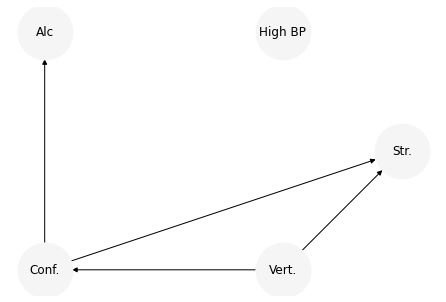

Random Graph


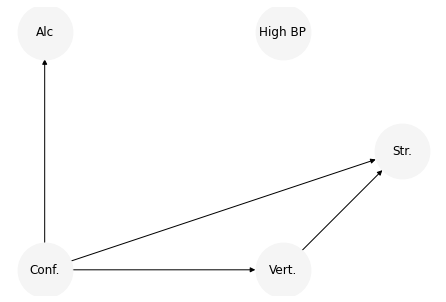

Pre-defined Graph


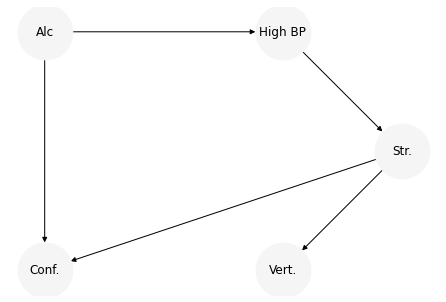

####### Graphs of  medium  dataset size ###########
Ordered Graph


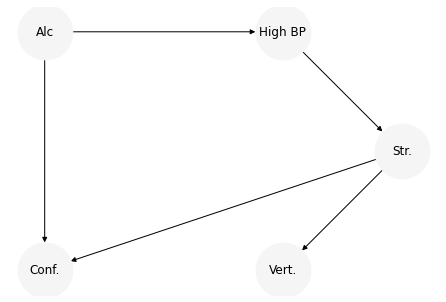

Reverse Graph


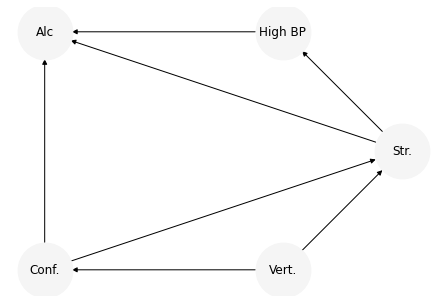

Random Graph


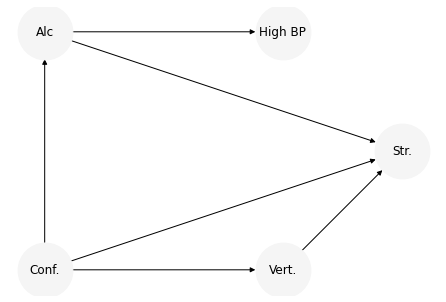

Pre-defined Graph


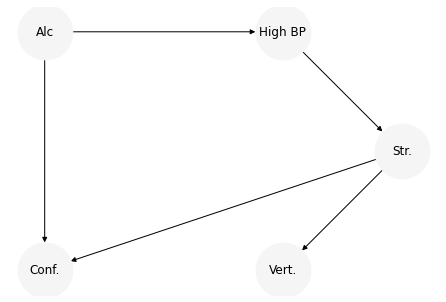

####### Graphs of  big  dataset size ###########
Ordered Graph


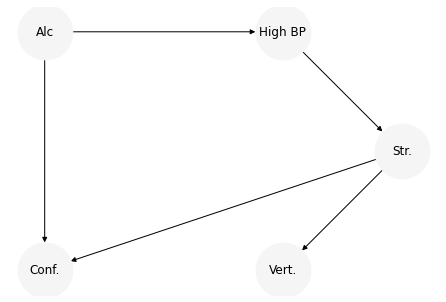

Reverse Graph


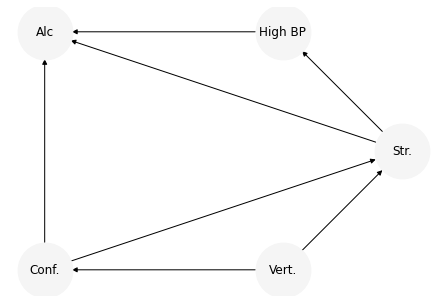

Random Graph


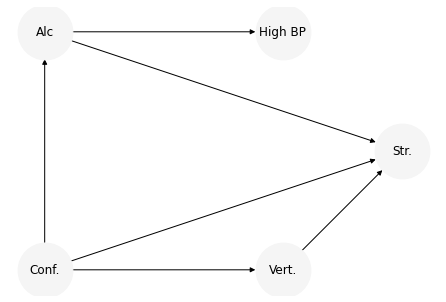

Pre-defined Graph


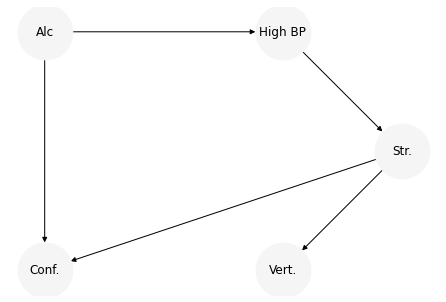

In [13]:
pdts = [maximum_likelihood_estimate(data, indices[0], indices[1:]) for indices in model2_ps3_indices]
model2_ps3 = BayesNet(*zip(pdts, model2_ps3_indices))


models = {}

for data_set_size in ['small', 'medium', 'big']:
            models[data_set_size] = {
                    'ordered': None,
                    'reverse': None,
                    'random': None,
                    'log-likelihood': None,
                    'pre-defined': None 
            }    
for data_set_size, data in zip(['small', 'medium', 'big'], [train_small, train_medium, train_big]):
    for combination_id, order in zip(
        ['ordered', 'reverse', 'random', 'log-likelihood', 'pre-defined'], 
        [[_A_, _H_, _S_, _C_, _V_], [_V_, _C_, _S_, _H_, _A_], [_C_, _A_, _H_, _V_, _S_], [_A_, _H_, _S_, _C_, _V_], None]
    ):
        if combination_id == 'log-likelihood':
            models[data_set_size][combination_id] = learn_net(data, order, score_fun=log_likelihood)
        elif combination_id == 'pre-defined':
            models[data_set_size][combination_id] = BayesNet(*zip(
                [maximum_likelihood_estimate(data, indices[0], indices[1:]) for indices in model2_ps3_indices], 
                model2_ps3_indices
            ))
        else:
            models[data_set_size][combination_id] = learn_net(data, order)

    print('####### Graphs of ',data_set_size,' dataset size ###########')
    print('Ordered Graph')
    draw_graph(models[data_set_size]['ordered'])
    print('Reverse Graph')
    draw_graph(models[data_set_size]['reverse'])
    print('Random Graph')
    draw_graph(models[data_set_size]['random'])
    print('Pre-defined Graph')
    draw_graph(models[data_set_size]['pre-defined'])


In [14]:
for data_set_id in ['small', 'medium', 'big']:
    for combination_id in ['ordered', 'reverse', 'random', 'log-likelihood', 'pre-defined']:
        assert type(models[data_set_id][combination_id]) is BayesNet
        

### Interpret the Results in Detail

Inspect the following plots:
 - In the first plot, we visualize the training set size's influence on the log-likelihood relative to the test data.

- In the second plot, we compare all configurations' log-likelihood relative to the training and test data for each dataset size.

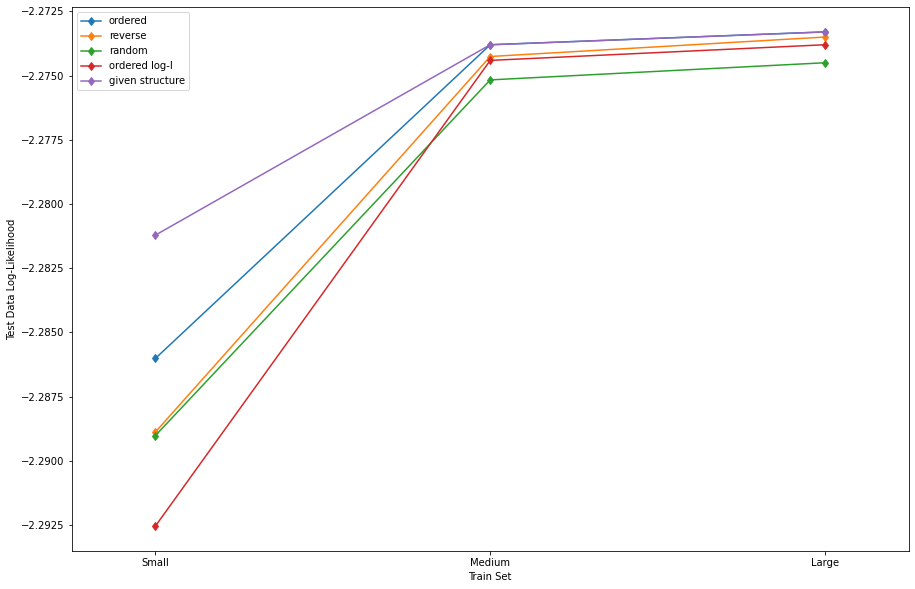

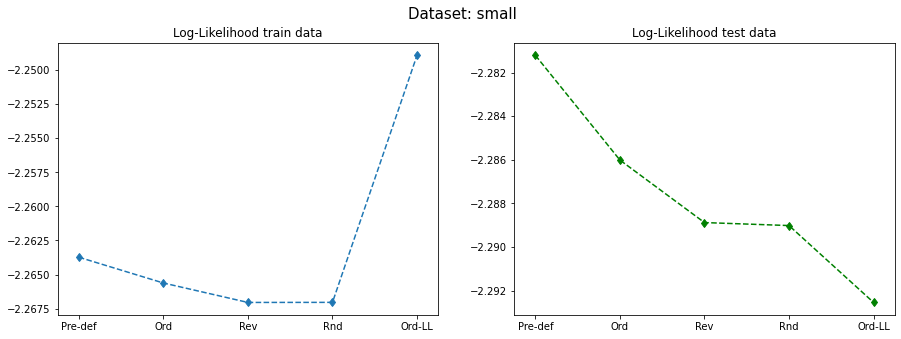

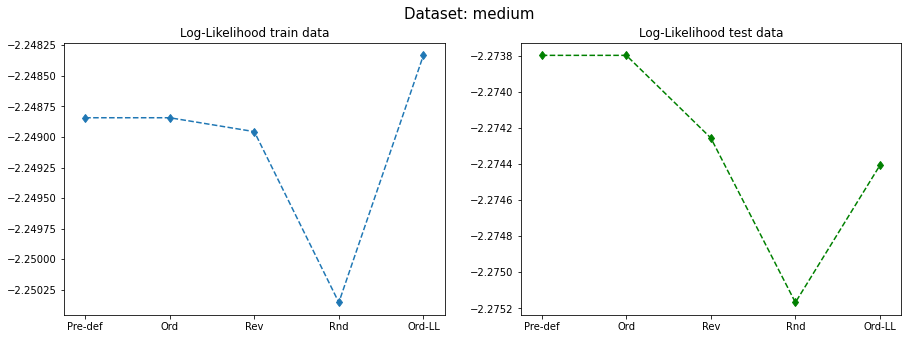

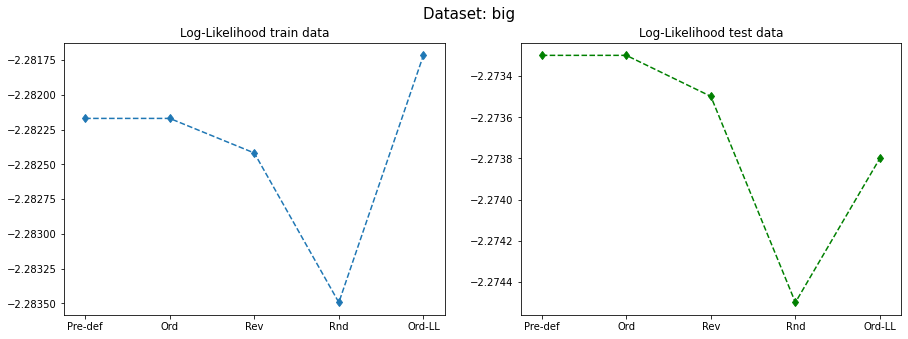

In [15]:
from utils import plot_compare_orders, compare_train_size

compare_train_size(models, [train_small, train_medium, train_big], test)
plot_compare_orders(models, [train_small, train_medium, train_big], test)